In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, regexp_extract, when

# Import thư viện Python để vẽ biểu đồ
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
spark = SparkSession.builder \
    .appName("GenomicAnalysis_Chr22") \
    .getOrCreate()

print("Spark Session đã sẵn sàng!")
print(spark)

25/11/05 07:47:12 WARN Utils: Your hostname, Admin-PC resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/11/05 07:47:12 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/11/05 07:47:15 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session đã sẵn sàng!


In [3]:
# Định nghĩa tên file (vì nó nằm chung thư mục, ta chỉ cần tên)
vcf_file = "file:///mnt/d/Genome/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf"

# Dùng Spark để đọc file
# Kết quả là một DataFrame có 1 cột duy nhất tên là "value"
df = spark.read.text(vcf_file)

print(f"Đã nạp file: {vcf_file}")

Đã nạp file: file:///mnt/d/Genome/ALL.chr22.phase3_shapeit2_mvncall_integrated_v5a.20130502.genotypes.vcf


In [6]:
from pyspark.sql.functions import col

# Tạo một DataFrame mới, chỉ chứa các dòng KHÔNG bắt đầu bằng "##"
df_no_meta = df.filter(~col("value").startswith("##"))

In [7]:
header_line = df_no_meta.first()["value"]
column_names = header_line.split("\t")

# Lọc bỏ dòng header này để chỉ còn dữ liệu
df_data = df_no_meta.filter(~col("value").startswith("#CHROM"))

# Tách dòng "value" bằng ký tự tab (\t)
# Chúng ta chỉ cần 8 cột đầu tiên (không cần 3000 cột sample)
df_parsed = df_data.withColumn("fields", split(col("value"), "\t")) \
                   .select(
                       col("fields")[0].alias("CHROM"),
                       col("fields")[1].alias("POS").cast("integer"),
                       col("fields")[2].alias("ID"),
                       col("fields")[3].alias("REF"),
                       col("fields")[4].alias("ALT"),
                       col("fields")[7].alias("INFO")  # Cột INFO là quan trọng nhất
                   )

print("Đã tách xong 8 cột đầu tiên:")
df_parsed.show(5)

Đã tách xong 8 cột đầu tiên:
+-----+--------+-----------+---+---+--------------------+
|CHROM|     POS|         ID|REF|ALT|                INFO|
+-----+--------+-----------+---+---+--------------------+
|   22|16050075|rs587697622|  A|  G|AC=1;AF=0.0001996...|
|   22|16050115|rs587755077|  G|  A|AC=32;AF=0.006389...|
|   22|16050213|rs587654921|  C|  T|AC=38;AF=0.007587...|
|   22|16050319|rs587712275|  C|  T|AC=1;AF=0.0001996...|
|   22|16050527|rs587769434|  C|  A|AC=1;AF=0.0001996...|
+-----+--------+-----------+---+---+--------------------+
only showing top 5 rows



In [8]:
# Dùng regexp_extract để tìm "AF=..." và lấy số
# r"AF=([\d\.]+)" nghĩa là: tìm "AF=", sau đó lấy (group 1) tất cả số [0-9] và dấu chấm
df_with_af = df_parsed.withColumn(
    "AF_str", 
    regexp_extract(col("INFO"), r"AF=([\d\.]+)", 1)
)

# Lọc bỏ các dòng không có AF và chuyển AF sang dạng số (float)
df_af = df_with_af.filter(col("AF_str") != "") \
                  .withColumn("AF", col("AF_str").cast("float"))

print("Đã trích xuất AF (Tần suất Alen):")
df_af.select("ID", "INFO", "AF").show(10, truncate=50)

Đã trích xuất AF (Tần suất Alen):
+-------------------------------------------+--------------------------------------------------+----------+
|                                         ID|                                              INFO|        AF|
+-------------------------------------------+--------------------------------------------------+----------+
|                                rs587697622|AC=1;AF=0.000199681;AN=5008;NS=2504;DP=8012;EAS...|1.99681E-4|
|                                rs587755077|AC=32;AF=0.00638978;AN=5008;NS=2504;DP=11468;EA...|0.00638978|
|                                rs587654921|AC=38;AF=0.00758786;AN=5008;NS=2504;DP=15092;EA...|0.00758786|
|                                rs587712275|AC=1;AF=0.000199681;AN=5008;NS=2504;DP=22609;EA...|1.99681E-4|
|                                rs587769434|AC=1;AF=0.000199681;AN=5008;NS=2504;DP=23591;EA...|1.99681E-4|
|                                rs587638893|AC=2;AF=0.000399361;AN=5008;NS=2504;DP=21258;EA...|3.9936

In [9]:
# Phân loại AF vào 3 nhóm
df_binned = df_af.withColumn(
    "AF_Category",
    when(col("AF") < 0.01, "Hiếm (AF < 1%)")
    .when((col("AF") >= 0.01) & (col("AF") < 0.05), "Thường (1% <= AF < 5%)")
    .otherwise("Phổ biến (AF >= 5%)")
)

# Đếm số lượng trong mỗi nhóm
# Đây là một phép toán "groupBy" kinh điển của Big Data
af_counts = df_binned.groupBy("AF_Category").count()

print("Kết quả đếm (từ Spark):")
af_counts.show()

Kết quả đếm (từ Spark):


[Stage 3:========================================================>(83 + 1) / 84]

+--------------------+------+
|         AF_Category| count|
+--------------------+------+
| Phổ biến (AF >= 5%)|114322|
|      Hiếm (AF < 1%)|909281|
|Thường (1% <= AF ...| 79944|
+--------------------+------+



In [10]:
# Kéo kết quả từ Spark về máy local (dưới dạng Pandas)
local_af_counts = af_counts.toPandas()

print("Kết quả đã chuyển sang Pandas:")
print(local_af_counts.head())

[Stage 6:========================================================>(83 + 1) / 84]

Kết quả đã chuyển sang Pandas:
              AF_Category   count
0     Phổ biến (AF >= 5%)  114322
1          Hiếm (AF < 1%)  909281
2  Thường (1% <= AF < 5%)   79944


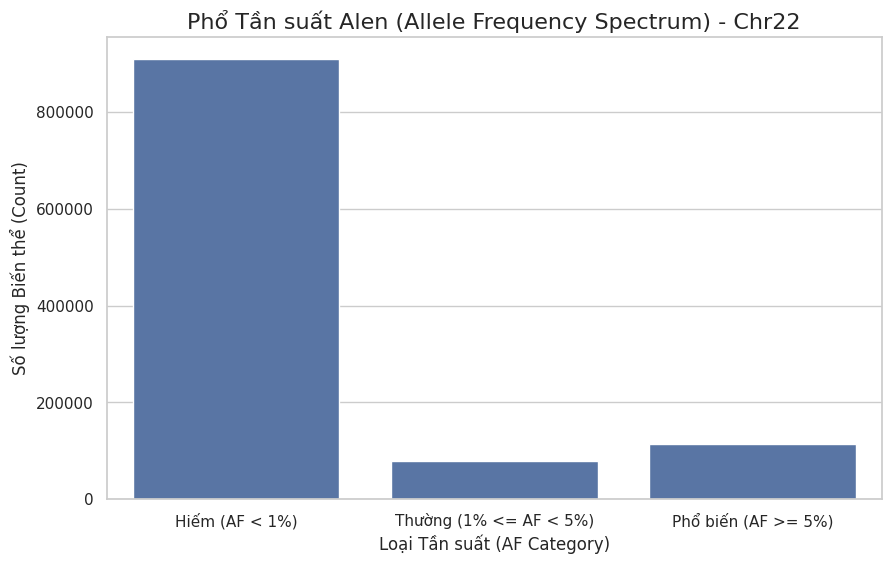

In [11]:
# Dùng %matplotlib inline để Jupyter hiển thị biểu đồ
%matplotlib inline

plt.figure(figsize=(10, 6)) # Thiết lập kích thước
sns.set(style="whitegrid") # Dùng style 'whitegrid'

# Vẽ biểu đồ cột
barplot = sns.barplot(
    data=local_af_counts, 
    x="AF_Category", 
    y="count",
    order=["Hiếm (AF < 1%)", "Thường (1% <= AF < 5%)", "Phổ biến (AF >= 5%)"] # Sắp xếp thứ tự
)

plt.title("Phổ Tần suất Alen (Allele Frequency Spectrum) - Chr22", fontsize=16)
plt.xlabel("Loại Tần suất (AF Category)", fontsize=12)
plt.ylabel("Số lượng Biến thể (Count)", fontsize=12)
plt.show()